<a href="https://colab.research.google.com/github/chwonghk01/typo-detection/blob/master/BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [74]:
from google.colab import auth
auth.authenticate_user()

project_id = 'data-poc-227904'
!gcloud config set project {project_id}

import os
import tensorflow as tf
import json
TPU_WORKER = 'grpc://' + os.environ['COLAB_TPU_ADDR']
with tf.Session(TPU_WORKER) as session:
  # Upload credentials to TPU.
  with open('/content/adc.json', 'r') as f:
    auth_info = json.load(f)
  tf.contrib.cloud.configure_gcs(session, credentials=auth_info)
  # Now credentials are set for all future sessions on this TPU.
  
print(tf.VERSION)
print(tf.keras.__version__)


Updated property [core/project].
1.12.0
2.1.6-tf


In [54]:
!mkdir -p assets && gsutil -m rsync -rd gs://hk01dev-typo-detection/assets ./assets
!mkdir -p dataset && gsutil -m rsync -rd gs://hk01dev-typo-detection/dataset ./dataset
!gsutil -m cp gs://hk01dev-typo-detection/code/*.py .

Building synchronization state...
Starting synchronization...
Building synchronization state...
Starting synchronization...
Copying gs://hk01dev-typo-detection/dataset/test_128_0.01_1.00.tfrecords...
Copying gs://hk01dev-typo-detection/dataset/test_128_0.15_0.80.tfrecords...
Copying gs://hk01dev-typo-detection/dataset/train_128_0.15_0.80.tfrecords...
- [3/3 files][281.2 MiB/281.2 MiB] 100% Done                                    
Operation completed over 3 objects/281.2 MiB.                                    
Copying gs://hk01dev-typo-detection/code/assets.py...
Copying gs://hk01dev-typo-detection/code/config.py...
Copying gs://hk01dev-typo-detection/code/examine.py...
Copying gs://hk01dev-typo-detection/code/input.py...
Copying gs://hk01dev-typo-detection/code/dataset.py...
Copying gs://hk01dev-typo-detection/code/train.py...
Copying gs://hk01dev-typo-detection/code/predict.py...
Copying gs://hk01dev-typo-detection/code/model.py...
Copying gs://hk01dev-typo-detection/code/transform.p

In [0]:
!gsutil -m cp gs://hk01dev-typo-detection/code/*.py .
!python train.py \
  --use_tpu=true \
  --tpu_name={TPU_WORKER} \
  --assets_dir=./assets \
  --bert_model_ch_dir=gs://hk01dev-typo-detection/assets/chinese_L-12_H-768_A-12 \
  --checkpoint_dir=gs://hk01dev-typo-detection/ckpt \
  --training_data=gs://hk01dev-typo-detection/dataset/train_128_0.15_0.80.tfrecords \
  --output_dir=gs://hk01dev-typo-detection/model \
  --testing_data=gs://hk01dev-typo-detection/dataset/test_128_0.01_1.00.tfrecords \
  --num_epoch=10 \
  --train_steps_per_epoch=1000 \
  --eval_steps_per_epoch=500
  

Copying gs://hk01dev-typo-detection/code/config.py...
Copying gs://hk01dev-typo-detection/code/dataset.py...
Copying gs://hk01dev-typo-detection/code/assets.py...
Copying gs://hk01dev-typo-detection/code/examine.py...
Copying gs://hk01dev-typo-detection/code/model.py...
Copying gs://hk01dev-typo-detection/code/input.py...
Copying gs://hk01dev-typo-detection/code/utils.py...
Copying gs://hk01dev-typo-detection/code/transform.py...
Copying gs://hk01dev-typo-detection/code/predict.py...
Copying gs://hk01dev-typo-detection/code/train.py...
Copying gs://hk01dev-typo-detection/code/visualize.py...
/ [11/11 files][ 35.5 KiB/ 35.5 KiB] 100% Done                                  
Operation completed over 11 objects/35.5 KiB.                                    
INFO:tensorflow:Using config: {'_model_dir': 'gs://hk01dev-typo-detection/ckpt', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement

In [0]:
!gsutil -m cp gs://hk01dev-typo-detection/code/*.py .
!python predict.py \
  --use_tpu=true \
  --tpu_name={TPU_WORKER} \
  --assets_dir=./assets \
  --bert_model_ch_dir=gs://hk01dev-typo-detection/assets/chinese_L-12_H-768_A-12 \
  --checkpoint_dir=gs://hk01dev-typo-detection/ckpt \
  --input_data=gs://hk01dev-typo-detection/dataset/train_128_0.01_0.80.tfrecords

In [0]:
ASSERTS_DIR = './assets' #@param{'type': 'string'}
INPUT_DATA = 'gs://hk01dev-typo-detection/dataset/train_128_0.15_0.80.tfrecords' #@param{'type': 'string'}
MAX_SEQ_LENGTH = 128 #@param{'type': 'integer'}
BATCH_SIZE = 64 #@param{'type': 'integer'}


pred = None
# import pickle
# with open('result.pkl', 'rb') as f:
#   _, _, pred = pickle.load(f)

  
import tensorflow as tf
import os
from transform import create_tokenizer
import numpy as np
from utils import visualize

import sys
sys.path.append('./assets')

from input import input_fn_builder
tf.logging.set_verbosity(tf.logging.INFO)

input_fn = input_fn_builder(
    input_file=INPUT_DATA,
    seq_length=MAX_SEQ_LENGTH,
    is_training=False,
    drop_remainder=True
)

with tf.Session() as sess:
    tensor = input_fn(params={'batch_size': BATCH_SIZE}).make_one_shot_iterator().get_next()
    inp = sess.run(tensor)

input_ids = inp['input_ids']
truth = inp['truths']
tokenizer = create_tokenizer()
text = np.array([tokenizer.convert_ids_to_tokens(input_id) for input_id in input_ids])

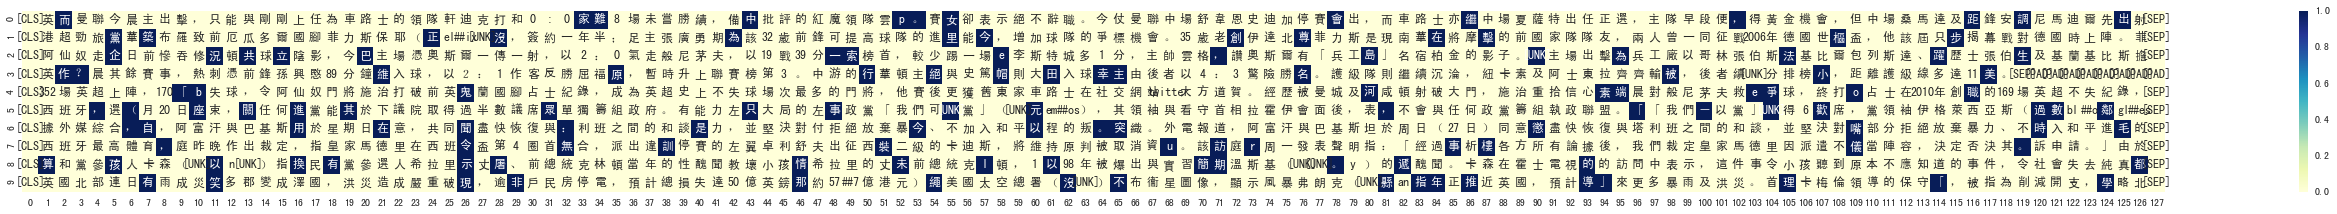

In [65]:
visualize(ASSERTS_DIR, text, truth, pred=pred, display_rows=10)